In [17]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [18]:
# Dataframe einlesen
df = pd.read_parquet(r'c:\Users\abadi\Gold_Projekt\gold-team\data\processed\gold_macro_combined.parquet')
df.head()

,Gold,USD_Index,EUR_USD,SP_500,Oil,Bitcoin,Vix,CPI,Unemployment_Rate,GPD,US_Interest_Rate,Zinsen,Gold_ETFs,M2_Euro,M2_US,GPRD
Date,,,,,,,,,,,,,,,,
2010-01-01,1117.699951,77.529999,1.438994,1132.98999,81.510002,NaN,20.040001,216.687000,9.8,14764.610000,0.110000,0.110000,NaN,8.234925e+12,8478.0,200.210129
2010-01-02,1117.699951,77.529999,1.438994,1132.98999,81.510002,NaN,20.040001,216.688742,9.8,14767.005367,0.110645,0.110645,NaN,8.234151e+12,8479.6,110.146950
2010-01-03,1117.699951,77.529999,1.438994,1132.98999,81.510002,NaN,20.040001,216.690484,9.8,14769.400733,0.111290,0.111290,NaN,8.233376e+12,8481.2,91.471298
2010-01-04,1117.699951,77.529999,1.442398,1132.98999,81.510002,NaN,20.040001,216.692226,9.8,14771.796100,0.111935,0.111935,24.59,8.232602e+12,8482.8,177.117065
2010-01-05,1118.099976,77.620003,1.436596,1136.52002,81.769997,NaN,19.350000,216.693968,9.8,14774.191467,0.112581,0.112581,23.34,8.231827e+12,8484.4,122.525620


In [19]:
# sicherstellen , dass index als Timestamp ist
df.index = pd.to_datetime(df.index)

In [20]:
# numersiche kontinuierliche fehlende Werte füllen
df['Gold_ETFs'] = df['Gold_ETFs'].fillna(df['Gold_ETFs'].mean())
df['GPRD'] = df['GPRD'].fillna(df['GPRD'].mean())

In [21]:
# neues Dataframe, wo Price von Bitcoin anfängt
df = df[df.index >= '01-01-2024']

<Axes: ylabel='Frequency'>

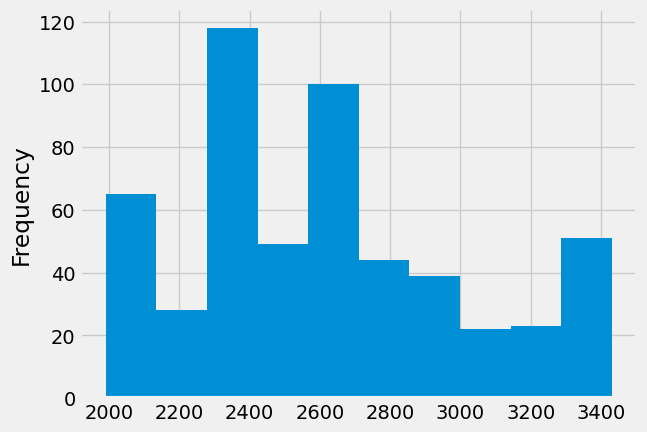

In [22]:
df['Gold'].plot(kind='hist')

In [23]:
df.head()

,Gold,USD_Index,EUR_USD,SP_500,Oil,Bitcoin,Vix,CPI,Unemployment_Rate,GPD,US_Interest_Rate,Zinsen,Gold_ETFs,M2_Euro,M2_US,GPRD
Date,,,,,,,,,,,,,,,,
2024-01-01,2062.399902,101.330002,1.105583,4769.830078,71.650002,44167.332031,12.45,308.417000,3.700000,28624.069000,5.33,5.33,15.76,1.087614e+13,20773.100000,167.600159
2024-01-02,2064.399902,102.199997,1.103875,4742.830078,70.379997,44957.968750,13.20,308.478581,3.706452,28628.383780,5.33,5.33,15.73,1.087614e+13,20775.941935,131.122467
2024-01-03,2034.199951,102.459999,1.094176,4704.810059,72.699997,42848.175781,14.04,308.540161,3.712903,28632.698560,5.33,5.33,14.85,1.087614e+13,20778.783871,142.895081
2024-01-04,2042.300049,102.419998,1.092777,4688.680176,72.190002,44179.921875,14.13,308.601742,3.719355,28637.013341,5.33,5.33,14.20,1.087614e+13,20781.625806,180.685516
2024-01-05,2042.400024,102.410004,1.094739,4697.240234,73.809998,44162.691406,13.35,308.663323,3.725806,28641.328121,5.33,5.33,13.81,1.087614e+13,20784.467742,167.489380


In [24]:
'''
# Time Features erstellen 
def create_time_features(df):
    """
    Create temporal features from datetime index
    """

    df['day_of_week'] = df.index.dayofweek  # 0=Monday, 6=sunday
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    # Binary Features
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_year_start'] = df.index.is_year_start.astype(int)
    df['is_year_end'] = df.index.is_year_end.astype(int)

    
    return df

'''

'\n# Time Features erstellen \ndef create_time_features(df):\n    """\n    Create temporal features from datetime index\n    """\n\n    df[\'day_of_week\'] = df.index.dayofweek  # 0=Monday, 6=sunday\n    df[\'day_of_month\'] = df.index.day\n    df[\'week_of_year\'] = df.index.isocalendar().week\n    df[\'month\'] = df.index.month\n    df[\'quarter\'] = df.index.quarter\n    df[\'year\'] = df.index.year\n\n    # Binary Features\n    df[\'is_weekend\'] = (df.index.dayofweek >= 5).astype(int)\n    df[\'is_month_start\'] = df.index.is_month_start.astype(int)\n    df[\'is_month_end\'] = df.index.is_month_end.astype(int)\n    df[\'is_quarter_start\'] = df.index.is_quarter_start.astype(int)\n    df[\'is_quarter_end\'] = df.index.is_quarter_end.astype(int)\n    df[\'is_year_start\'] = df.index.is_year_start.astype(int)\n    df[\'is_year_end\'] = df.index.is_year_end.astype(int)\n\n    \n    return df\n\n'

In [25]:
'''
# Lag Features erstellen
def create_lag_features(df, target_col='Gold_log', lags=[1, 7, 30, 60]):
    """
    Create lagged features for the target variable (daily frequency)
    lags = [1day, 2days, 3days, 1week, 2weeks, 3weeks, 1month, 2months, 3months]
    """
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

'''

'\n# Lag Features erstellen\ndef create_lag_features(df, target_col=\'Gold_log\', lags=[1, 7, 30, 60]):\n    """\n    Create lagged features for the target variable (daily frequency)\n    lags = [1day, 2days, 3days, 1week, 2weeks, 3weeks, 1month, 2months, 3months]\n    """\n    for lag in lags:\n        df[f\'{target_col}_lag_{lag}\'] = df[target_col].shift(lag)\n    return df\n\n'

In [26]:
'''
# Rolling Features erstellen
def create_rolling_features(df, target_col='Gold_log', windows=[5, 10, 20, 30, 60]):
    """
    Create rolling statistical features for daily data
    windows = [1week, 2weeks, 1month, 2months, 3months, 6months]
    """
    for window in windows:
        df[f"{target_col}_roll_mean_{window}"] = df[target_col].rolling(window=window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window=window).std()

        return df
'''


'\n# Rolling Features erstellen\ndef create_rolling_features(df, target_col=\'Gold_log\', windows=[5, 10, 20, 30, 60]):\n    """\n    Create rolling statistical features for daily data\n    windows = [1week, 2weeks, 1month, 2months, 3months, 6months]\n    """\n    for window in windows:\n        df[f"{target_col}_roll_mean_{window}"] = df[target_col].rolling(window=window).mean()\n        df[f\'{target_col}_roll_std_{window}\'] = df[target_col].rolling(window=window).std()\n\n        return df\n'

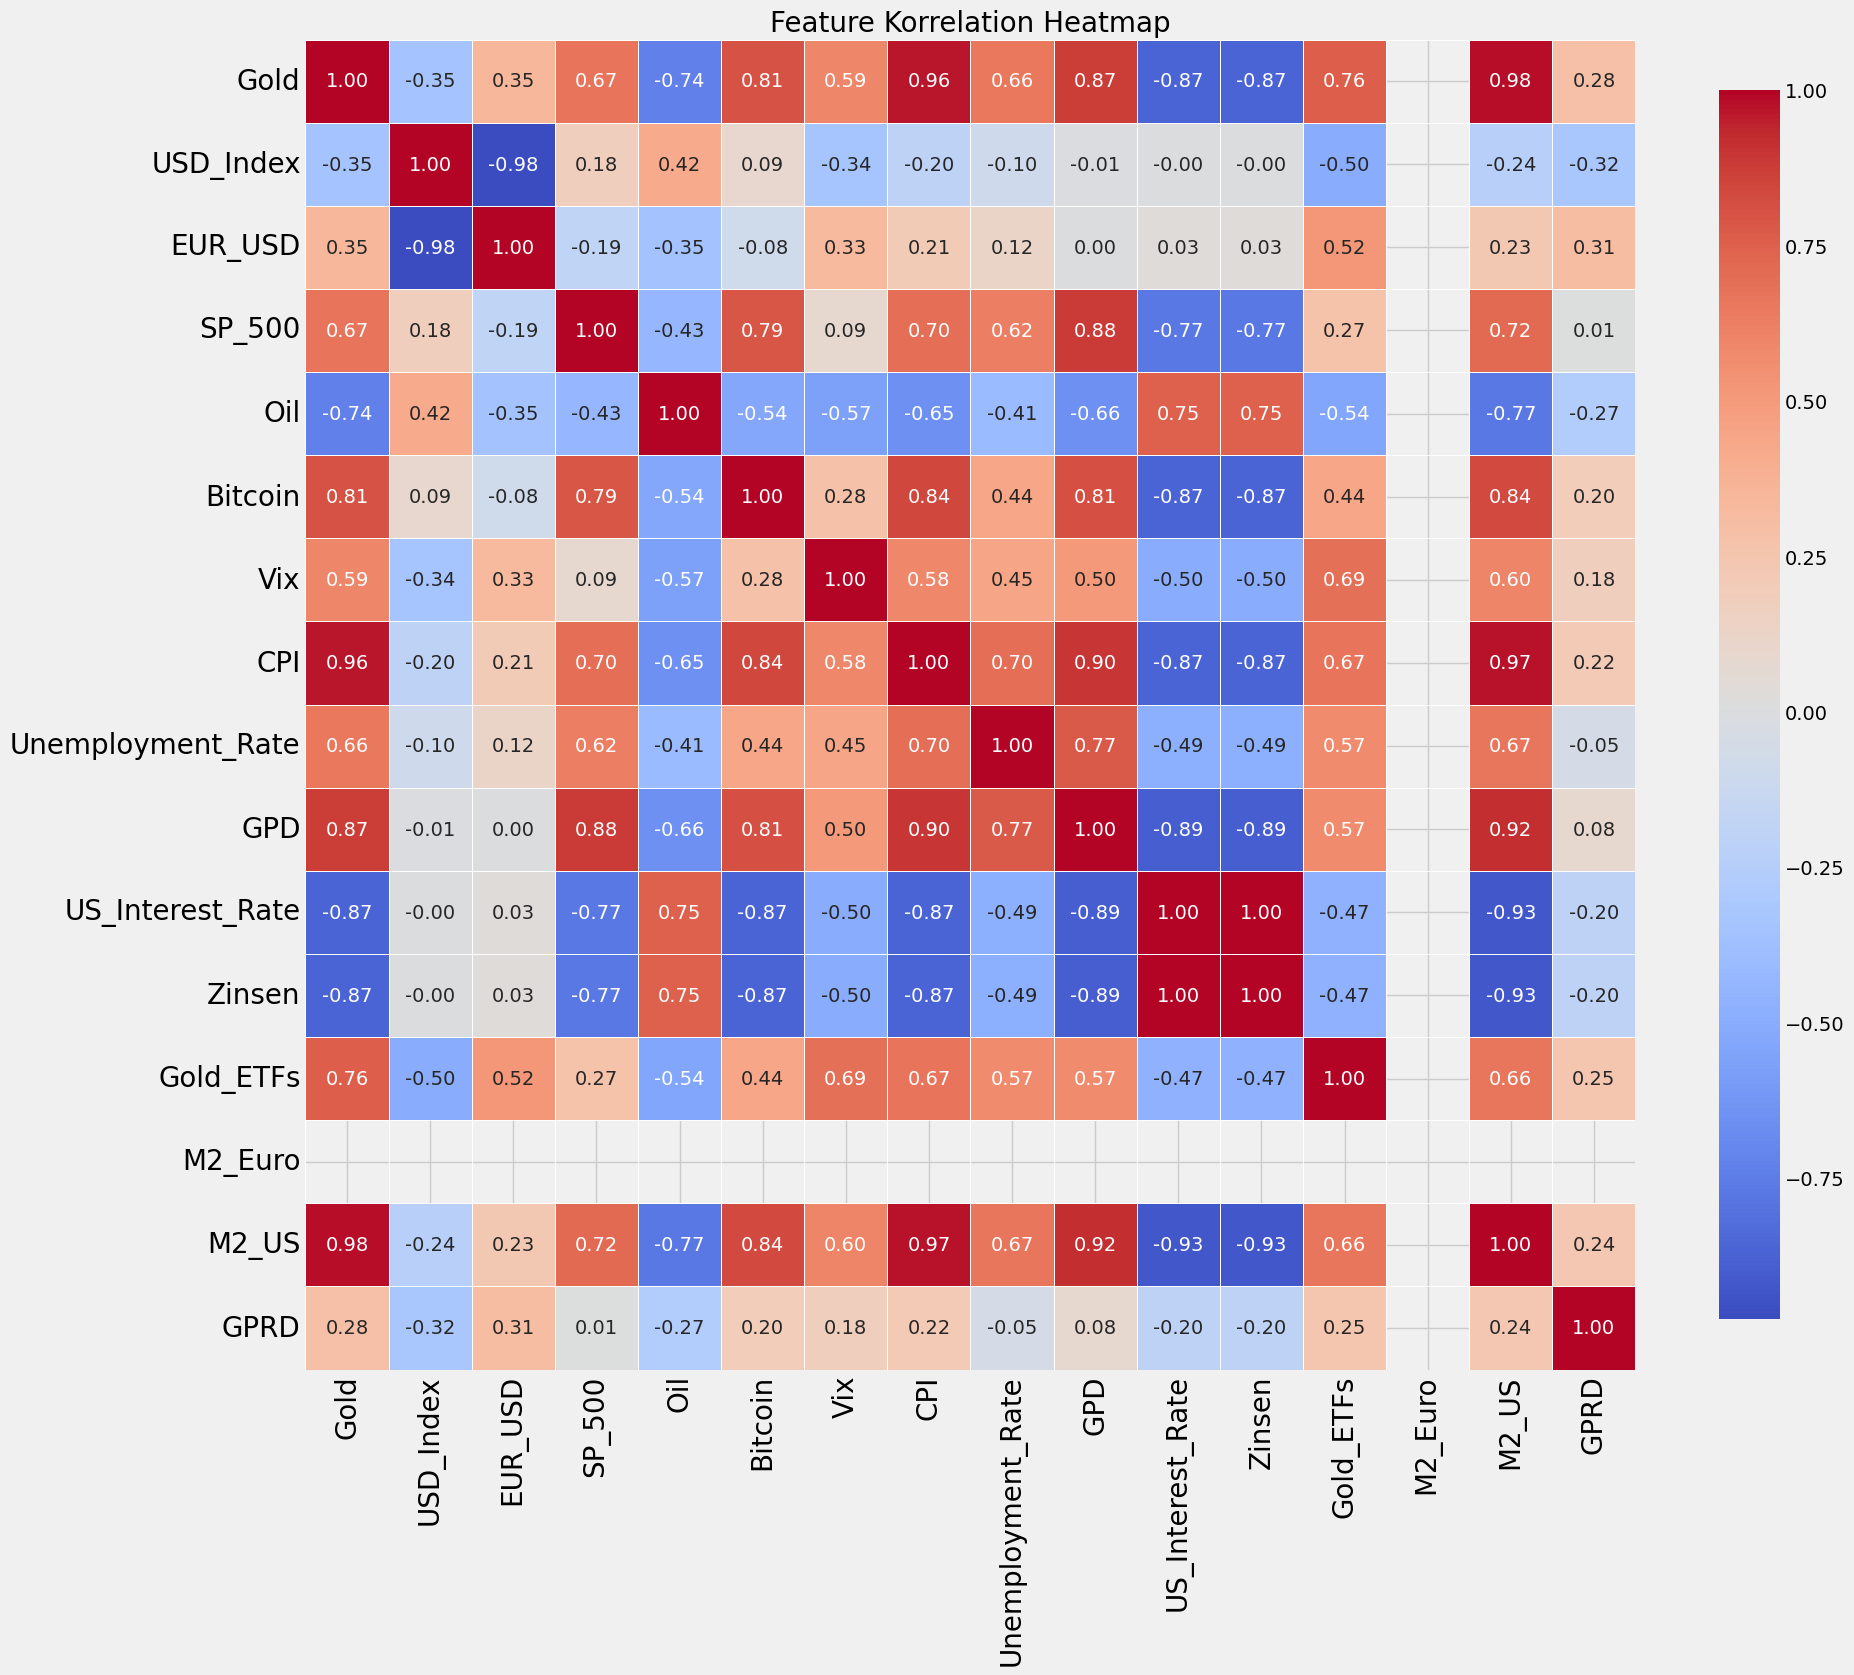

In [27]:
# Korrelation prüfen mit Korrelationsmatrix

# Matrix berechnen (nicht Stationär)
corr_matrix = df.corr()

# Plotting
plt.figure(figsize=(20,25))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',annot_kws={"size": 14}, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Feature Korrelation Heatmap', fontsize=20)
plt.tight_layout()
plt.show()

In [28]:
'''
# aus Heatmap sind folgende Features hoch korreliert
# 'Unemployment_Rate', 'EUR_USD', 'Vix', 'GPD' (hoch mit sp500), 'M2_Euro','US_Interest_Rate','Zinsen', 'CPI', 'Bitcoin'

df.drop(['Unemployment_Rate', 'EUR_USD', 'Vix', 'GPD' , 'M2_Euro','US_Interest_Rate','Zinsen', 'CPI', 'Bitcoin'], axis=1, inplace=True)
df.head()
'''

"\n# aus Heatmap sind folgende Features hoch korreliert\n# 'Unemployment_Rate', 'EUR_USD', 'Vix', 'GPD' (hoch mit sp500), 'M2_Euro','US_Interest_Rate','Zinsen', 'CPI', 'Bitcoin'\n\ndf.drop(['Unemployment_Rate', 'EUR_USD', 'Vix', 'GPD' , 'M2_Euro','US_Interest_Rate','Zinsen', 'CPI', 'Bitcoin'], axis=1, inplace=True)\ndf.head()\n"

In [29]:
'''
df = create_time_features(df)
df = create_lag_features(df, 'Gold')
df = create_rolling_features(df, 'Gold')
df.dropna(inplace=True)

'''

"\ndf = create_time_features(df)\ndf = create_lag_features(df, 'Gold')\ndf = create_rolling_features(df, 'Gold')\ndf.dropna(inplace=True)\n\n"

In [30]:
df.drop('M2_Euro', axis=1, inplace=True)

In [31]:
X = df.drop(columns=['Gold'])
y = df['Gold']

In [32]:
# Time Series Cross Validation
n_splits = 5
test_size = 14
cv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Model and Parameter Grid definieren
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.001, 0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBRegressor(
    n_jobs=-1,
    tree_method='hist'
)


In [33]:
#Grid Search ausführen 

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print(f"Best RMSE: {-grid_search.best_score_:.4f}")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Best RMSE: 47.8690


In [34]:
# Bests Model mit CV Splits evaluieren

rmse_scores = []

for train_idx, val_idx in cv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    preds = best_model.predict(X_val)
    
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)

print("\n Cross-Validation RMSE:")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} ")



 Cross-Validation RMSE:
Mean RMSE: 47.8690 
